## Imports

In [4]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt


import numpy as np
# from tqdm import tqdm
import scipy
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())

%matplotlib inline

/home/daniel/anaconda3/envs/mthesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data (of a single time slice)

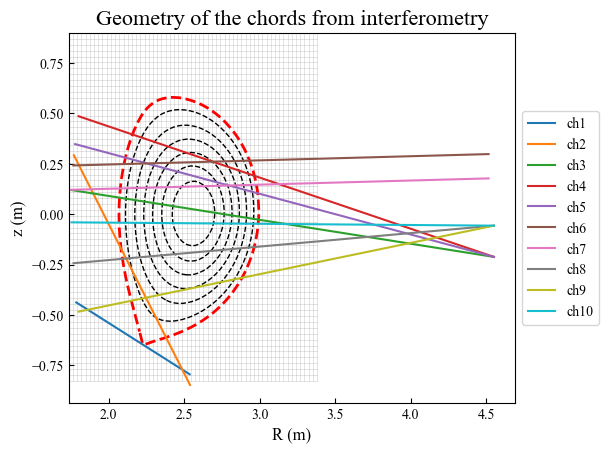

In [5]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Plotting The NICE profile and vrious Data Options

The responce martix is applied to the NICE profile to generate ground truth data for a simulation where NICE is the exact profile in the TOKAMAK.

Some noise is added to the ground truth data to generate synthetic data.

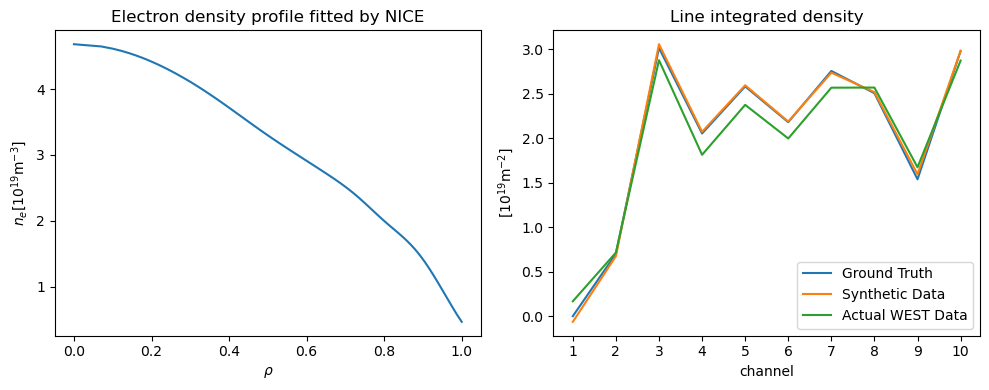

In [12]:
EXP_ER = 0.03 #background noise order of magnitude
M = len(interf.channels.compressed()) #number of channels 
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data
                                          
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nice = dens_prof.dens_1d
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='Ground Truth')
ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')
ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()





# Setting Data

In [14]:
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)

# Ground Trueth. Assuming a profile is true what is the exact LID for each channel?
# lid_d = lid_true
# Synthetic data, gaussian noise added to ground truth
lid_d = lid_data
# Real Data for each channel from west
# lid_d = interf.lid.compressed()


# Static OR non-Static Kernel

array([[30.46490322, 30.41776247, 30.36985143, ..., 20.03626718,
        19.41257571, 18.62400039],
       [30.41776247, 30.46490322, 30.45656081, ..., 21.15982426,
        20.55346939, 19.78091953],
       [30.36985143, 30.45656081, 30.46490322, ..., 21.62453916,
        21.02650691, 20.26199867],
       ...,
       [20.03626718, 21.15982426, 21.62453916, ..., 30.46490322,
        30.44239362, 30.34629842],
       [19.41257571, 20.55346939, 21.02650691, ..., 30.44239362,
        30.46490322, 30.42689998],
       [18.62400039, 19.78091953, 20.26199867, ..., 30.34629842,
        30.42689998, 30.46490322]])

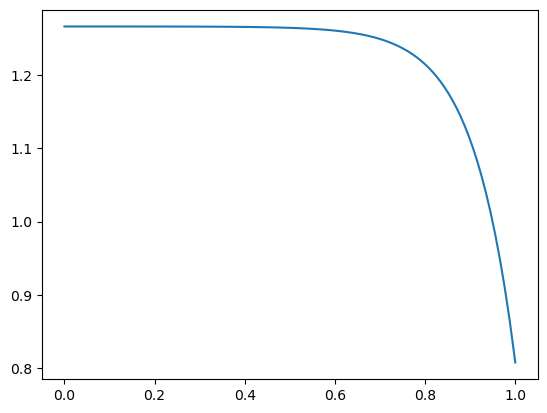

In [18]:

def parabola(rho):
    return 4.9*(1-rho**2)
mu_prior = np.zeros(N)#parabola(rho_1d)#np.zeros(N)#dens_prof.dens_1d#
#exponential square kernel

STATIC = 3
# 1 means completly static
# 2 means static amp but non static length-scale
# 3 means static amp but non static length-scale with a hyperbolic tangent functional form 
# 4 means static amp but non static length-scale with a exonential decay functional form 
# 5 means non static length scale and amp

if STATIC==1:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        return amp**2 * np.ones((len(rho_1d),len(rho_1d)))#* np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    initial_params = [4,0.19]
    # initial_params = [5.62,1.37]
    # initial_params = [5.62,10]
elif STATIC==2:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[1:])
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))    
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_1d)-3)))
    initial_params = ([5.62]+list(np.repeat(1.37,len(rho_1d))))
    #exponential decay of correlation length. Creates a flat area at 0.
    # l_initial = list(10*np.exp(-2*rho_1d))
    # initial_params = ([5.62]+l_initial)
    # plt.plot(rho_1d,l)

elif STATIC==3:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        def HyperTan_l(rho, params):
            core_l, edge_l, transition_center, transition_width = params[1:]
            return ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * np.tanh((rho - transition_center)/transition_width))
        l = HyperTan_l(rho_1d, params)
        plt.plot(rho_1d,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    initial_params = ([ 30.46490307,   1.26607835, -12.65929225,   1.30549892,
         0.18071757])#([5.62,2,0.1,0.7,0.1])
    
elif STATIC==4:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        core_l, edge_l, drop_rate = params[1:]
        def ExpDecay_l(rho):
            return core_l * np.exp(-drop_rate*rho) + edge_l
        l = ExpDecay_l(rho_1d)
        plt.plot(rho_1d,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_1d)-3)))
    
    initial_params = ([5.62,10,1,9])

    
elif STATIC==5:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[:N]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[N:])
        LA, LB = np.meshgrid(l,l)
        AMPA, AMPB = np.meshgrid(amp,amp)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)    
        return (3*AMPA*AMPB / AMPA*AMPA+AMPB*AMPB) * frac * np.exp(-(mag/scale2))
    # initial_params = list(np.repeat(5.62,N))+list(np.repeat(1.37,N))
    initial_params = list(np.repeat(5.62,N))[:-1]+[0.5]+list(np.repeat(1.37,N))
    
Kernel(rho_1d, initial_params)



Not good if zero, as need to be chol_inverted.
The Determinent of K is: 1.2796e-320
The Determinent of cov_li is: 2.43e-08
The Determinent of cov_post3 is: 2e-323


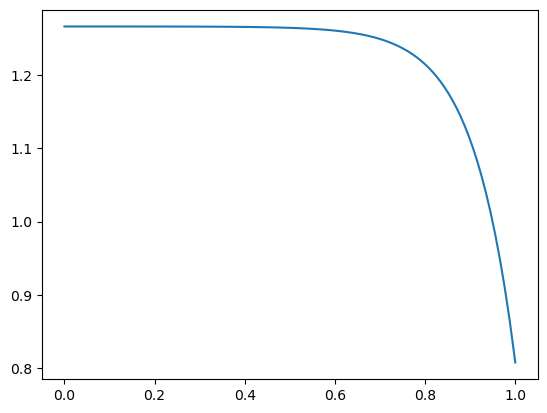

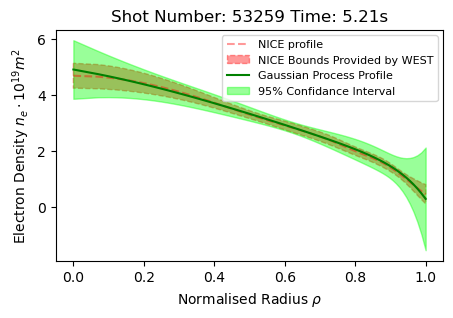

In [19]:
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

def KRcov_li(params,trial_EXP_ER):
    #covergence matrix of Prior
    K = Kernel(rho_1d, params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_EXP_ER,M)) # M is number of channels
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,EXP_ER)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8
    if np.isinf(invertable).any() or np.isnan(invertable).any():
        print('matrix has an inf or nan with causes issues for square root, reurning inf for marginal likelihood')
        return float('inf')
    elif np.any(np.linalg.eigvals(invertable) <= 0):
        print('Matrix is not positive definate, returning inf for marginal likelyhood')
        return float('inf')
    return 0.5*np.log(chol_det(invertable)) + 0.5*(lid_d.T@chol_inv(invertable)@lid_d)                
  

# results = minimize(MargLi, x0=initial_params)
# results = basinhopping(MargLi, x0=initial_params, niter=2)
# print(results)
# best_params = results.x
# initial_params = ([0.1, 0.1, 0.1,   0.1,
#          0.1])
best_params = initial_params
# MargLi(x0)

def PlotBest(params,trial_EXP_ER): 
    K, R, cov_li = KRcov_li(params,trial_EXP_ER)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_d - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    plt.legend(fontsize = 8)
    plt.show()
    return mu_post3, cov_post3

post_mu, post_cov = PlotBest(best_params, EXP_ER)

Text(0.5, 1.0, 'Non Stationary Length Scale')

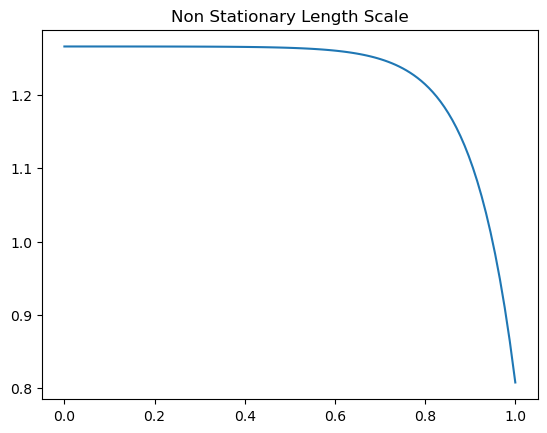

In [31]:
def HyperTan_l(rho, params):
            core_l, edge_l, transition_center, transition_width = params[1:]
            return ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * np.tanh((rho - transition_center)/transition_width))
plt.plot(rho_1d,HyperTan_l(rho_1d, best_params))
plt.title('Non Stationary Length Scale')


In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 10)
    l = trial.suggest_float('l', 0, 0.2)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

# Including Potential Reflectometry Data

If I get reflectometry data I can use vanilla GPR with the prior being the posterior from forward model GPR. Here is me testing that pipeline. I suspect I can do something similar to include arificial observations.

## Informative Vanilla GPR

This can take a prior and insert it into vanilla GPR with some extra data and output a new posterior. It uses interpolation of the prior to get the covariance between predicted positions and new data positions.

The next step is to add gradient information

In [20]:
prior_mu = post_mu
prior_cov = post_cov

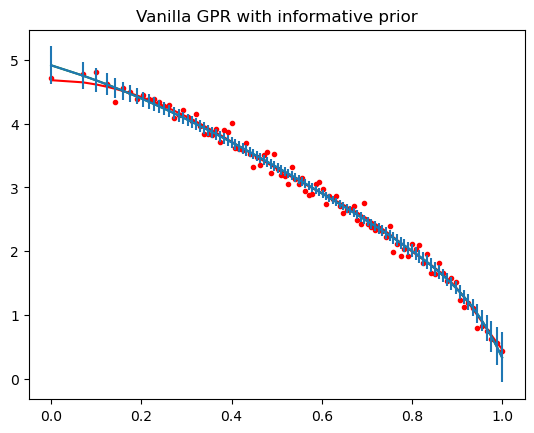

In [50]:
#Informative GP1, Informative vanilla GPR

def InformativeVanillaGPR(x_test, xd, yd, yd_noise, prior_mu, prior_cov):
    def InterpolatePrior(x1, x2):
        interp = scipy.interpolate.RegularGridInterpolator((rho_1d,rho_1d), prior_cov, method='linear', bounds_error=True, fill_value=float('nan'))
        X1, X2 = np.meshgrid(x1,x2)
        return interp((X1,X2))
        
    Kstst = prior_cov#Kernel(X1st, X2st,best_params)
    K = InterpolatePrior(xd, xd) 
    K[np.diag_indices_from(K)] += 1e-8 
    Kst = InterpolatePrior(x_test,xd)#Kernel(X22, X1st2,best_params)

    
    cov_D = K + np.diag(yd_noise)

    interp_prior_mu = scipy.interpolate.interp1d(rho_1d, prior_mu, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=float('nan'), assume_sorted=False)
    prior_at_xd = interp_prior_mu(xd)
    cov_post = Kstst - Kst.T @ chol_inv(cov_D) @ Kst
    mu_post = prior_mu + Kst.T @ chol_inv(cov_D) @ (yd - prior_at_xd)
    error_bars = np.sqrt(np.diagonal(cov_post))

    figGPR1 = plt.figure()
    plt.title('Vanilla GPR with informative prior')
    plt.plot(x_test,nice,'r', label='NICE Profile')
    plt.plot(xd,yd,'r.', label='Crude Reflectometry Data')
    plt.plot(x_test,mu_post,'g', label='New Inference')
    plt.errorbar(x_test, mu_post, yerr=error_bars, label='New Inference')
    plt.show()

refl_M = 101
refl_rho = rho_1d[:refl_M]
refl_ne = nice[:refl_M] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data
VanillaGPR(x_test=rho_1d, xd=refl_rho, yd=refl_ne, yd_noise=np.repeat(0.5,refl_M), prior_mu=prior_mu, prior_cov=prior_cov)

In [22]:
type(None)

NoneType

## Adding Gradient Information

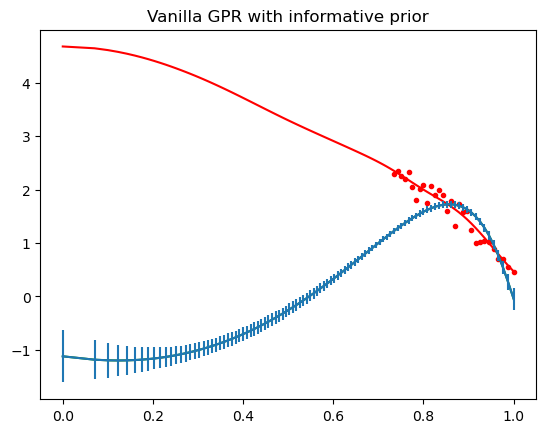

In [70]:
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
#Informative GP1, Informative vanilla GPR

def InformativeVanillaGPR(x_test, xd, yd, yd_noise, prior_mu, prior_cov, xd_prime=None, yd_prime=None, yd_prime_noise=None):
    def InterpolatePrior(x1, x2):
        interp = scipy.interpolate.RegularGridInterpolator((rho_1d,rho_1d), prior_cov, method='linear', bounds_error=True, fill_value=float('nan'))
        X1, X2 = np.meshgrid(x1,x2)
        return interp((X1,X2))
    
    if type(yd_prime) != type(None) and type(xd_prime)!=type(None) and type(yd_prime_noise)!=type(None):
        have_grad = True
    else: print('Error, not enough gradient information')
    
    Kstst = prior_cov
    
    if not have_grad:
        K = InterpolatePrior(xd, xd)
        
        K[np.diag_indices_from(K)] += 1e-8
        Kst = InterpolatePrior(x_test,xd)
        cov_D = K + np.diag(yd_noise)

    elif have_grad:
        K_n_n = InterpolatePrior(xd, xd)
        K_p_p = np.gradient(np.gradient(InterpolatePrior(xd_prime, xd_prime), axis=0), axis=1)
        K_n_p = np.gradient(InterpolatePrior(xd_prime, xd), axis=0)#might need correcting
        K_p_n = K_n_p.T
        K = np.block([[K_n_n, K_n_p],
                      [K_p_n, K_p_p]])  
        Kst = np.hstack((InterpolatePrior(xd,x_test), np.gradient(InterpolatePrior(xd_prime,x_test),axis=1)))
        cov_D = K + np.diag(np.hstack((yd_noise, yd_prime_noise)))

    interp_prior_mu = scipy.interpolate.interp1d(rho_1d, prior_mu, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=float('nan'), assume_sorted=False)
    prior_at_xd = interp_prior_mu(xd)
    cov_D[np.diag_indices_from(cov_D)] += 1e-8
    
    if have_grad: 
        prior_at_xd = np.append(prior_at_xd,np.zeros(len(xd_prime)))
        yd_full = np.append(yd,yd_prime)
#         mu_post = prior_mu + Kst @ chol_inv(cov_D) @ (yd_full - prior_at_xd)
        try:
            L = cholesky(cov_D, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                           "The kernel is not returning a positive "
                           "definite matrix.",
                       ) + exc.args
            raise
        alpha = cho_solve((L, True), yd_full, check_finite=False)
        yst = Kst @ alpha
        mu_post = yst
        
    else: mu_post = prior_mu + Kst @ chol_inv(cov_D) @ (yd - prior_at_xd)
    
    v = solve_triangular(L, Kst.T, lower=True, check_finite=False)
    cov_st = Kstst - v.T @ v
    cov_post = cov_st
    
#     cov_post = Kstst - Kst @ chol_inv(cov_D) @ Kst.T
    error_bars = np.sqrt(np.diagonal(cov_post))

    figGPR1 = plt.figure()
    plt.title('Vanilla GPR with informative prior')
    plt.plot(x_test,nice,'r', label='NICE Profile')
    plt.plot(xd,yd,'r.', label='Crude Reflectometry Data')
    plt.plot(x_test,mu_post,'g', label='New Inference')
    plt.errorbar(x_test, mu_post, yerr=error_bars, label='New Inference')
    plt.show()

refl_M = 30
                        

# refl_rho = rho_1d[-refl_M:]
# refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data
# InformativeVanillaGPR(x_test=rho_1d, xd=np.array([1,0.9]), yd=np.array([0,0]), yd_noise=np.array([0.1,0.1]), prior_mu=prior_mu,
#            prior_cov=prior_cov, xd_prime=np.array([0,0.01,0.02,0.03,1]), yd_prime=np.array([0,0,0,0,0]), yd_prime_noise=np.array([0.1,0.1,0.1,0.1,0.1]))

refl_rho = rho_1d[-refl_M:]
refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data
InformativeVanillaGPR(x_test=rho_1d, xd=refl_rho, yd=refl_ne, yd_noise=np.repeat(0.1,refl_M), prior_mu=prior_mu,
           prior_cov=prior_cov, xd_prime=np.array([0,0.01]), yd_prime=np.array([0,0]), yd_prime_noise=np.array([0.1,0.1]))

In [27]:
import numpy as np
xd = np.array([1,2,3])
x_test = np.array([1,2,3,4])
xd_prime = np.array([1,2])


s1 = np.meshgrid(x_test,xd)[0]
s2 = np.gradient(np.meshgrid(x_test,xd_prime)[0],axis=1)
print(s1.shape)
print(s2.shape)
Kst = np.hstack((s1, s2))

(3, 4)
(2, 4)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 2

In [39]:
a = np.array([1,2,3])
b = np.array([1,2])
X,Y = np.meshgrid(a,b)
X, Y

f = np.append(a,(0,0,0))
f

array([1, 2, 3, 0, 0, 0])